In [1]:
import numpy as np
import pandas as pd

In [2]:
""" 讀檔
    groupby day
"""
data = pd.read_csv('data/PRSA_data_2010.1.1-2014.12.31.csv',
                   parse_dates=[['year', 'month', 'day']])

data = data.drop(['No','hour'], axis=1)
data = data.groupby(['year_month_day'])['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd',
                                        'Iws', 'Is', 'Ir'].mean().fillna(0)
print('shape:{}'.format(data.shape))

shape:(1826, 7)


In [3]:
data_Y = data.loc[:,'pm2.5']
data_X = data.drop(['pm2.5'], axis=1)

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
""" 正規化
"""
scaler = StandardScaler()
data_X = scaler.fit_transform(data_X)

In [6]:
""" 分train & test
"""
data_Y_log = np.log1p(data_Y).values
train_X = data_X[:-30]
train_Y = data_Y_log[1:-29]
test_X = data_X[-30:-1]
test_Y = data_Y_log[-29:]

In [10]:
""" reshape, 加入timesteps
    input shape 為三維
"""
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [11]:
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(1796, 1, 6)
(1796,)
(29, 1, 6)
(29,)


In [40]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras import callbacks, optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from math import sqrt

In [41]:
size = train_X.shape[0]
timesteps = train_X.shape[1]
data_dim = train_X.shape[2]

In [59]:
""" 預設activation function為 tanh
    防止過擬合可以加入 dropout*
"""

model = Sequential()
# lstm1
lstm_kwargs = {'return_sequences': True}
model.add(LSTM(128, input_shape=(timesteps, data_dim), **lstm_kwargs))
model.add(BatchNormalization())
# lstm2
lstm_kwargs = {'return_sequences': True}
model.add(LSTM(128, **lstm_kwargs))
model.add(BatchNormalization())
# lstm3
lstm_kwargs = {'return_sequences': False}
model.add(LSTM(64, **lstm_kwargs))
model.add(BatchNormalization())

model.add(Dense(1))

In [60]:
opt = optimizers.Adam(lr=0.001)
model.compile(loss='mse', optimizer=opt, metrics=['mse'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 1, 128)            69120     
_________________________________________________________________
batch_normalization_10 (Batc (None, 1, 128)            512       
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 128)            131584    
_________________________________________________________________
batch_normalization_11 (Batc (None, 1, 128)            512       
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                49408     
_________________________________________________________________
batch_normalization_12 (Batc (None, 64)                256       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total para

In [61]:
y_mean = train_Y.mean()

In [62]:
model.fit(train_X, train_Y-y_mean, batch_size=8, epochs=200, verbose=2)

Epoch 1/200
 - 7s - loss: 1.1881 - mean_squared_error: 1.1881
Epoch 2/200
 - 2s - loss: 0.9654 - mean_squared_error: 0.9654
Epoch 3/200
 - 2s - loss: 0.9600 - mean_squared_error: 0.9600
Epoch 4/200
 - 2s - loss: 0.9572 - mean_squared_error: 0.9572
Epoch 5/200
 - 2s - loss: 0.9366 - mean_squared_error: 0.9366
Epoch 6/200
 - 2s - loss: 0.9108 - mean_squared_error: 0.9108
Epoch 7/200
 - 2s - loss: 0.9299 - mean_squared_error: 0.9299
Epoch 8/200
 - 2s - loss: 0.9284 - mean_squared_error: 0.9284
Epoch 9/200
 - 2s - loss: 0.9272 - mean_squared_error: 0.9272
Epoch 10/200
 - 2s - loss: 0.9182 - mean_squared_error: 0.9182
Epoch 11/200
 - 2s - loss: 0.9074 - mean_squared_error: 0.9074
Epoch 12/200
 - 2s - loss: 0.9172 - mean_squared_error: 0.9172
Epoch 13/200
 - 2s - loss: 0.9402 - mean_squared_error: 0.9402
Epoch 14/200
 - 2s - loss: 0.9259 - mean_squared_error: 0.9259
Epoch 15/200
 - 2s - loss: 0.9236 - mean_squared_error: 0.9236
Epoch 16/200
 - 2s - loss: 0.9089 - mean_squared_error: 0.9089
E

Epoch 131/200
 - 2s - loss: 0.8437 - mean_squared_error: 0.8437
Epoch 132/200
 - 2s - loss: 0.8303 - mean_squared_error: 0.8303
Epoch 133/200
 - 2s - loss: 0.8306 - mean_squared_error: 0.8306
Epoch 134/200
 - 2s - loss: 0.8288 - mean_squared_error: 0.8288
Epoch 135/200
 - 2s - loss: 0.8266 - mean_squared_error: 0.8266
Epoch 136/200
 - 2s - loss: 0.8290 - mean_squared_error: 0.8290
Epoch 137/200
 - 2s - loss: 0.8205 - mean_squared_error: 0.8205
Epoch 138/200
 - 2s - loss: 0.8316 - mean_squared_error: 0.8316
Epoch 139/200
 - 2s - loss: 0.8281 - mean_squared_error: 0.8281
Epoch 140/200
 - 2s - loss: 0.8482 - mean_squared_error: 0.8482
Epoch 141/200
 - 2s - loss: 0.8194 - mean_squared_error: 0.8194
Epoch 142/200
 - 2s - loss: 0.8164 - mean_squared_error: 0.8164
Epoch 143/200
 - 3s - loss: 0.8327 - mean_squared_error: 0.8327
Epoch 144/200
 - 2s - loss: 0.8339 - mean_squared_error: 0.8339
Epoch 145/200
 - 2s - loss: 0.8169 - mean_squared_error: 0.8169
Epoch 146/200
 - 2s - loss: 0.8442 - mea

In [63]:
pred = (model.predict(test_X) + y_mean)
print('RMSE: {}'.format(sqrt(mean_squared_error(test_Y, pred))))

RMSE: 0.9266951473572926


In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

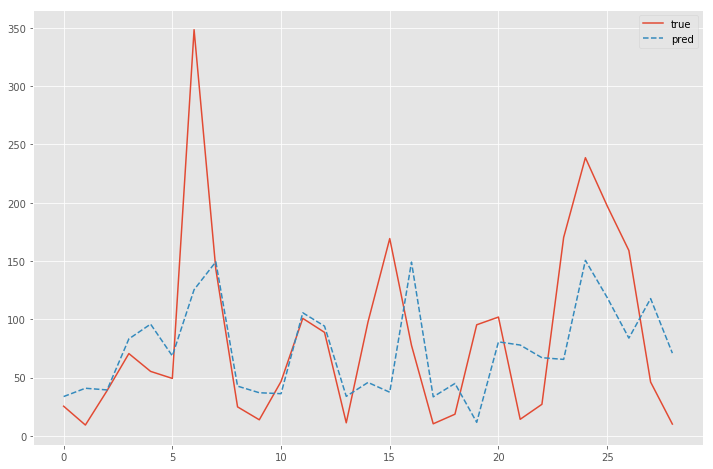

In [65]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
ax1.plot(np.expm1(test_Y), label='true', linestyle='-')
ax1.plot(np.expm1(pred),label='pred', linestyle='--')
ax1.legend(loc='best');
plt.show()